In [283]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, identity
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse import hstack
from scipy.sparse import vstack
from matplotlib.animation import FuncAnimation


In [284]:
# supplementary function for A matrix

def A_matrix(n):
    # initialize matrix with -30/12 and -2 values
    ind = np.arange(0, n-1, 1)
    vals = np.ones(n-1)
    diag = -2*vals
    A = sp.coo_matrix((diag, (ind,ind)), shape=(n-1, n-1)).tocsr()
    
    # add j-1 and j+1 entries
    diag_p1 = 1*vals
    A = A + sp.coo_matrix((diag_p1[0:n-2], (ind[0:n-2],ind[1:n-1])), shape=(n-1,n-1)).tocsr()
    diag_m1 = 1*vals
    A = A + sp.coo_matrix((diag_m1[0:n-2], (ind[1:n-1],ind[0:n-2])), shape=(n-1,n-1)).tocsr()
    
    # identity matrix of correct size
    I = sp.eye(n-1)

    return A, I

In [285]:
# 25*Sin(pi*x) Forcing Function
def g_function(x_values, t):
    first = np.zeros(n-1)
    second = 25*np.sin(np.pi*x_values)
    
    func = np.concatenate((first, second))
    
    return func

In [286]:
# No Forcing Function
def g_function(x_values, t):
    func = np.zeros(2*(n-1))
    
    return func

In [287]:
def u_true(x, t, E, I, mu):
    c = np.sqrt(E*I/mu)
    u_t = np.sin((np.pi/10)*x)*np.cos((np.pi/10)*c*t)
    return u_t

In [288]:
a = 0
b = 10
T = 10
n = 1000
E = 69 * 10**9
I = 1
mu = 25 * 10**9
dx = (b - a)/n
dt = .1
def Trap(E, I, mu, dt, n):
    dx = (b - a)/n
    Z = np.zeros((n-1, n-1))
    Z = sp.bsr_matrix(Z)
    A, eye = A_matrix(n)
    A = A*((E*I) / (mu*(dx**2)))

    M_matrix = vstack((hstack((Z,eye)), hstack((A, Z))))

    times = np.arange(0, T + dt, dt)
    x_values = np.arange(a, b, dx)[1:]


    v_0 = np.zeros(n - 1)
    u_0 = np.sin(np.pi/b*x_values)

    u = np.append(u_0, v_0)

    u_k = np.zeros((int(T/dt)+1,np.shape(M_matrix)[0]))
    u_k[0] = u

    eye_M = sp.eye((np.shape(M_matrix)[0]))
    M_inv = sp.linalg.inv(eye_M - 0.5*dt*M_matrix)
    M = eye_M + 0.5*dt*M_matrix


    for i in range(int(T/dt)):
        u_k[i+1] = (M_inv)*((M)*u_k[i] + (0.5)*dt*(g_function(x_values,dt*i) + g_function(x_values,dt*(i+1))))
    
    u_k = (u_k[: , 0:len(x_values)])
    
    u_k_max = np.amax(np.absolute(u_k))
    
    u_t = []
    for time in range(len(times)-1):
        u_t.append(u_true(x_values, time, E, I, mu))
    
    return u_k, x_values, times, u_k_max, u_t



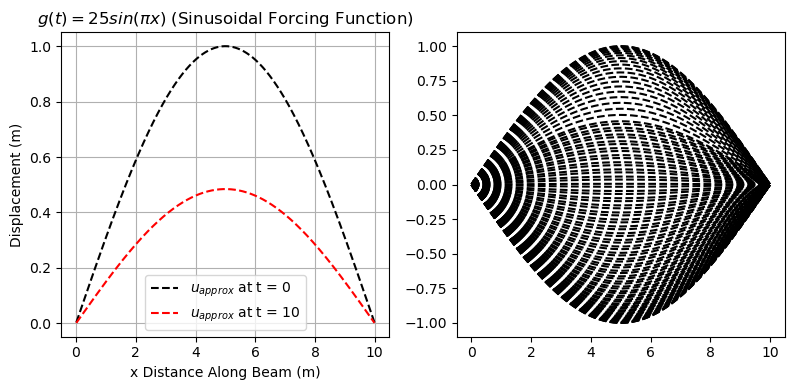

In [289]:
u_k, x_values, times, u_k_max, u_t = Trap(E, I, mu, dt, n)


u_0 = u_k[0]
u_final = u_k[-1]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax1 = fig.add_subplot(131)
ax1.plot(x_values, u_0, 'k--', label = '$u_{approx}$ at t = 0')
ax1.plot(x_values, u_final, 'r--', label = '$u_{approx}$ at t = 10')

ax2 = fig.add_subplot(132)
for i in range(100):
    u_approx = u_k[i]
    ax2.plot(x_values, u_approx, 'k--')

ax1.set_xlabel('x Distance Along Beam (m)')
ax1.set_ylabel('Displacement (m)')
ax1.grid()
ax1.set_title(r'$g(t) = 25sin(\pi x)$ (Sinusoidal Forcing Function)')
ax1.legend(loc='lower center')


In [290]:
def u_true(x, t, E, I, mu):
    c = np.sqrt(E*I/mu)
    u_t = np.sin((np.pi/10)*x)*np.cos((np.pi/10)*c*t)
    return u_t

In [291]:
def error_t(E, I, mu, dt, n):    
    u_k, x_values, times, maximum, u_t = Trap(E, I, mu, dt, n)
    u_t = u_true(x_values, T, E, I, mu)
    
    err = np.linalg.norm(u_k[-1] - u_t) / np.linalg.norm(u_t)
    return err

In [292]:
def error_x(E, I, mu, dt, n):    
    u_k, x_values, times, maximum, u_t = Trap(E, I, mu, dt, n)
    u_t = u_true(x_values, T, E, I, mu)
    
    err = np.linalg.norm(u_k[-1] - u_t) / np.linalg.norm(u_t)
    return err

## Error for Aluminum

In [293]:
dts = [1, 0.5, 0.25, 0.1, 0.05]
E = 69 * 10**9
mu = 25 * 10**9

err_list_t = []

u_k, x_values, times, maximum_al, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_al = max(err_list_t)

[0.2111185023886171, 0.053237474736469136, 0.013334513575635094, 0.002137687222660356, 0.0005373532999898416]


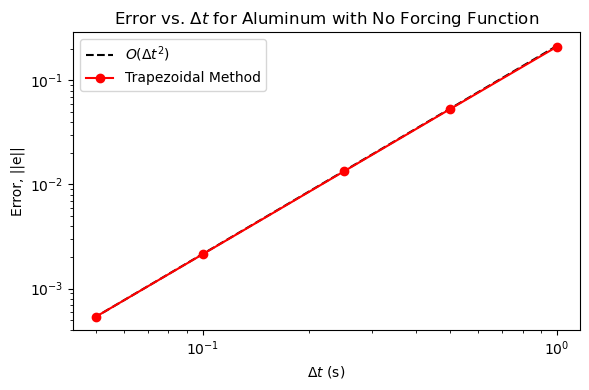

In [294]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dts, (ordert), color='black', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Aluminum with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)

In [295]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 69 * 10**9
mu = 25 * 10**9
dt = 0.1

err_list_x = []

u_k, x_values, times, maximum_al, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)

    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_al = max(err_list_x)

[0.04097060961777623, 0.011809723894412651, 0.004550677673594955, 0.0025204230006258743, 0.002230468375765256]


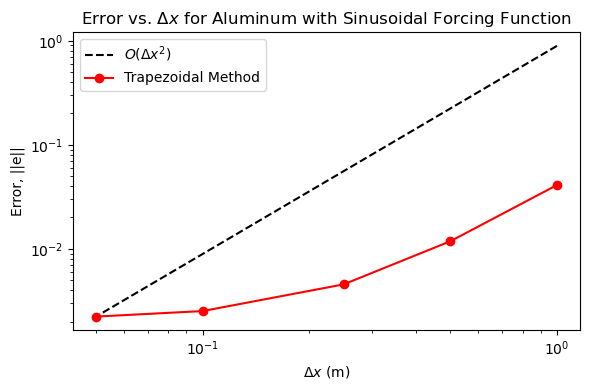

In [296]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_x)

## Error for Steel

In [297]:
E = 207 * 10**9
mu = 83 * 10**9
I = 1

err_list_t = []

u_k, x_values, times, maximum_st, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_st = max(err_list_t)

[0.39058567314336456, 0.09968227100348573, 0.025185109561708347, 0.00420323391515245, 0.0012014868972274782]


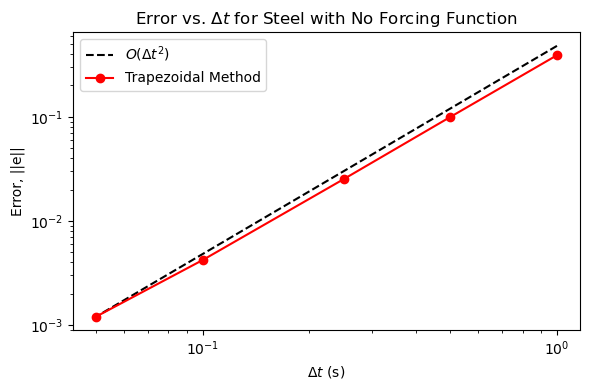

In [298]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dts, ordert, color='black', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Steel with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)

In [299]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 207 * 10**9
mu = 83 * 10**9
dt = 0.1

err_list_x = []

u_k, x_values, times, maximum_st, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)

    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_st = max(err_list_x)

[0.08434169295907024, 0.024068511301070388, 0.009017862116534011, 0.00480501999068811, 0.00420323391515245]


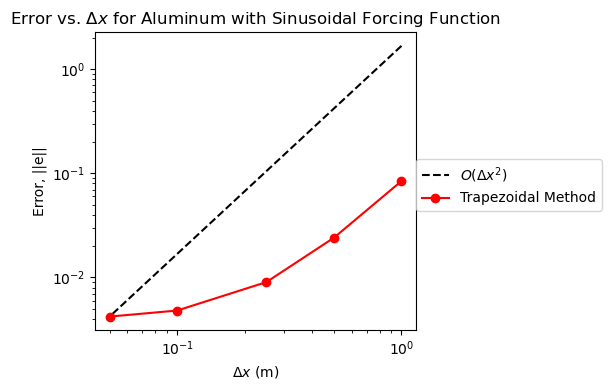

In [300]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=(1, 0.4))

print(err_list_x)

## Error for Brass

In [301]:
E = 97 * 10**9
mu = 37 * 10**9
I = 1

err_list_t = []

u_k, x_values, times, maximum_br, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_br = max(err_list_t)

[0.27405496853315336, 0.0696263600877166, 0.017564820376505447, 0.0029247531664561796, 0.000831127124336365]


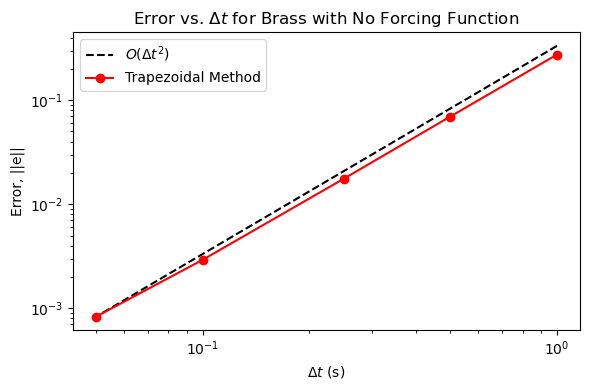

In [302]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dts, ordert, color='black', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Brass with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)


In [303]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 97 * 10**9
mu = 37 * 10**9
dt = 0.1

err_list_x = []

u_k, x_values, times, maximum_br, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)

    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_br = max(err_list_x)

[0.05618012967324376, 0.01611122882430156, 0.0061197760959955955, 0.0033240711742434713, 0.0029247531664561796]


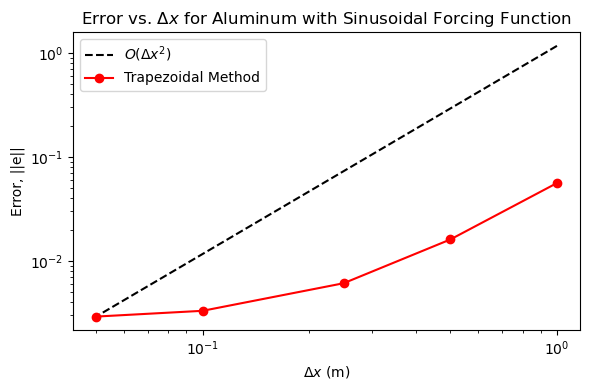

In [304]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_x)

## Error for Copper

In [305]:
E = 110 * 10**9
mu = 46 * 10**9
I = 1

err_list_t = []

u_k, x_values, times, maximum_cu, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_cu = max(err_list_t)

[0.632613528256585, 0.16193727009205772, 0.04095735097411433, 0.006848761104832708, 0.0019677760863392774]


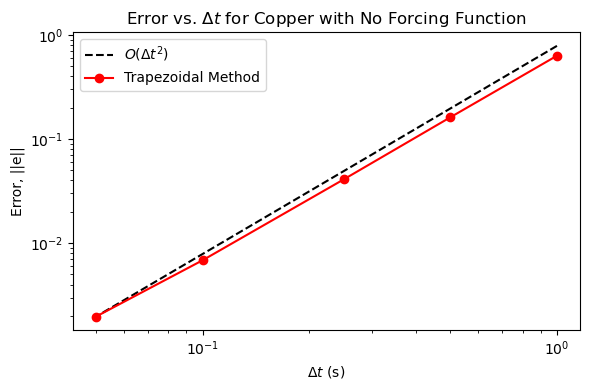

In [306]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dts, ordert, color='black', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Copper with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)

In [307]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 110 * 10**9
mu = 46 * 10**9
dt = 0.1

err_list_x = []

u_k, x_values, times, maximum_cu, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)

    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_cu = max(err_list_x)

[0.14259589210209409, 0.04052690516161455, 0.015012849977537697, 0.007869260483599134, 0.006848761104832708]


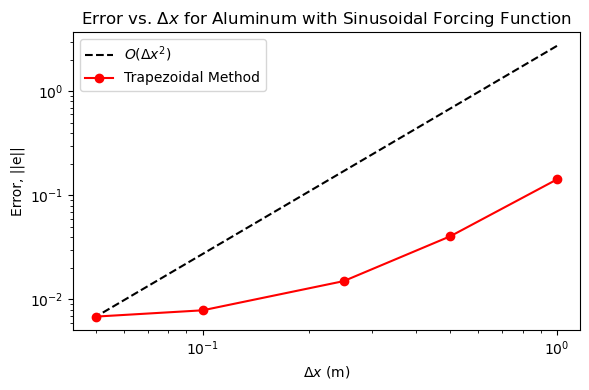

In [308]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_x)

## Error for Magnesium

In [309]:
E = 45 * 10**9
mu = 17 * 10**9
I = 1

err_list_t = []

u_k, x_values, times, maximum_mg, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_mg = max(err_list_t)

[0.2594792696671607, 0.06585573318476247, 0.016608067063971294, 0.002764212991331998, 0.0007846314968384948]


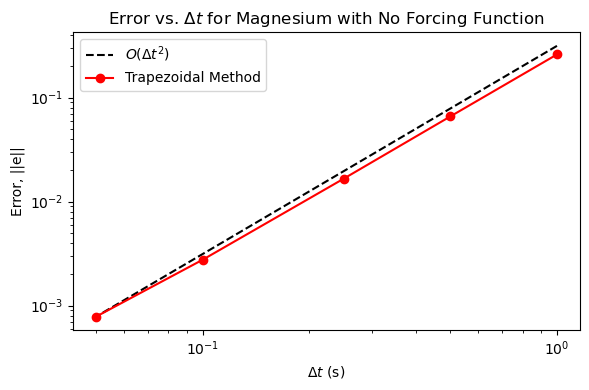

In [310]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dts, ordert, color='black', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Magnesium with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)

In [311]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 110 * 10**9
mu = 46 * 10**9
dt = 0.1


err_list_x = []

u_k, x_values, times, maximum_mg, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)
    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_mg = max(err_list_x)

[0.14259589210209409, 0.04052690516161455, 0.015012849977537697, 0.007869260483599134, 0.006848761104832708]


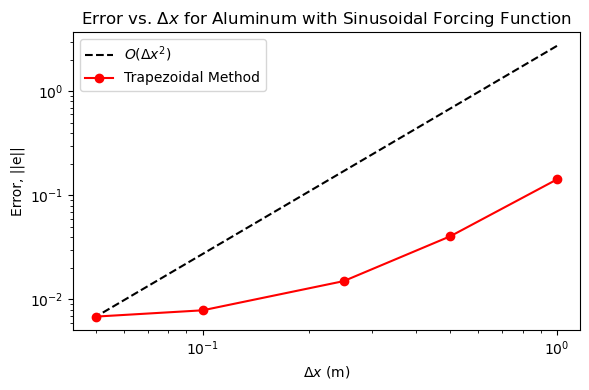

In [312]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_x)

## Error for Nickel

In [313]:
E = 207 * 10**9
mu = 76 * 10**9
I = 1

err_list_t = []

u_k, x_values, times, maximum_ni, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_ni = max(err_list_t)

[0.22444539726373533, 0.05677218985128921, 0.014301859828976025, 0.0023772248638551908, 0.000672595124432983]


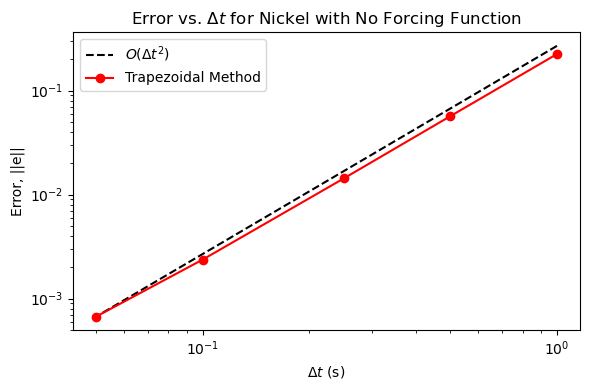

In [314]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dts, ordert, color='black', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Nickel with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)

In [315]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 110 * 10**9
mu = 46 * 10**9
dt = 0.1

err_list_x = []

u_k, x_values, times, maximum_ni, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)
    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_ni = max(err_list_x)

[0.14259589210209409, 0.04052690516161455, 0.015012849977537697, 0.007869260483599134, 0.006848761104832708]


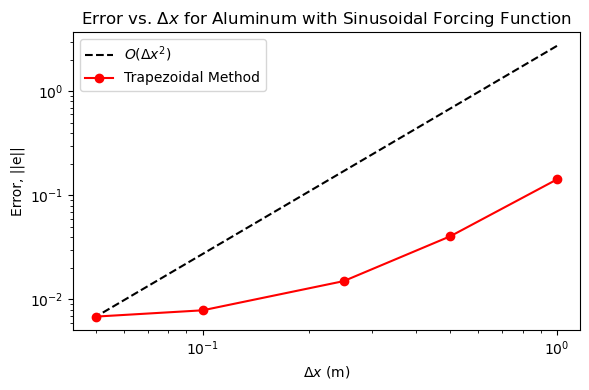

In [316]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_x)

## Error for Titanium

In [317]:
E = 107 * 10**9
mu = 45 * 10**9
I = 1

err_list_t = []

u_k, x_values, times, maximum_ti, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_ti = max(err_list_t)

[0.6932172201418978, 0.17751470725451401, 0.04490308479475726, 0.007510527098937689, 0.0021594348569553704]


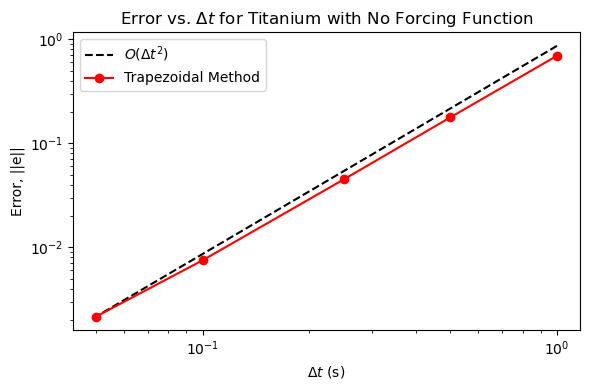

In [318]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dts, ordert, color='black', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Titanium with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)

In [319]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 110 * 10**9
mu = 46 * 10**9
dt = 0.1

err_list_x = []

u_k, x_values, times, maximum_ti, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)
    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_ti = max(err_list_x)

[0.14259589210209409, 0.04052690516161455, 0.015012849977537697, 0.007869260483599134, 0.006848761104832708]


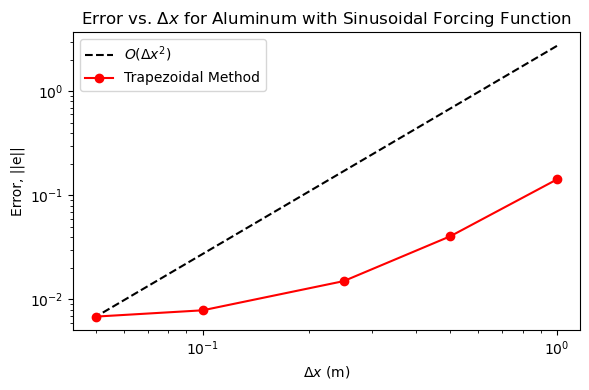

In [320]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_x)

## Error for Tungsten

In [321]:
E = 407 * 10**9
mu = 160 * 10**9
I = 1

err_list_t = []

u_k, x_values, times, maximum_tg, u_t = Trap(E, I, mu, dt, n)
for dt in dts:
    err_t = error_t(E, I, mu, dt, n)
    err_list_t.append(err_t)
    
f = dts[-1]**2/err_list_t[-1]
ordert = []
for dt in dts:
    ordert = np.append(ordert, [(dt**2/f)])
m_e_tg = max(err_list_t)

[0.33348774343031634, 0.08496979627693695, 0.021455931760278584, 0.0035776160187389744, 0.001020247535796168]


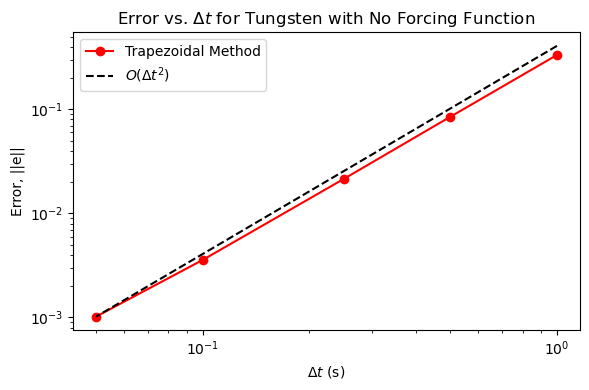

In [322]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)

ax.plot(dts, err_list_t,'ro-', label = 'Trapezoidal Method')
ax.plot(dts, ordert, color='black', linestyle='--', label='$O(\Delta t^2)$')

ax.set_xlabel('$\Delta t$ (s)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta t$ for Tungsten with No Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_t)

In [323]:
n = 1000
dxs = [1, 0.5, 0.25, 0.1, 0.05]
E = 110 * 10**9
mu = 46 * 10**9
dt = 0.1

err_list_x = []

u_k, x_values, times, maximum_tg, u_t = Trap(E, I, mu, dt, n)
for dx in dxs:
    n = int((b-a)/dx)
    err_x = error_x(E, I, mu, dt, n)
    err_list_x.append(err_x)
    
f = dxs[-1]**2/err_list_x[-1]
orderx = []
for dx in dxs:
    orderx = np.append(orderx, [(dx**2/f)])
m_e_x_tg = max(err_list_x)

[0.14259589210209409, 0.04052690516161455, 0.015012849977537697, 0.007869260483599134, 0.006848761104832708]


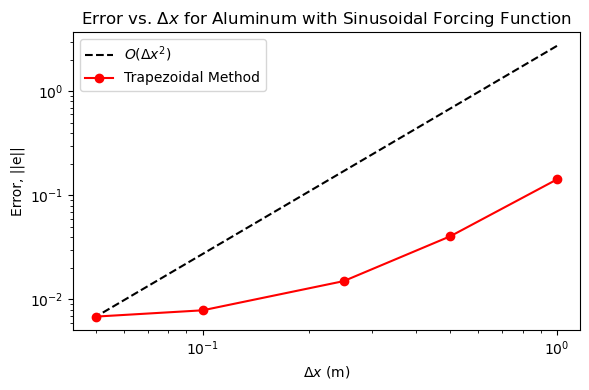

In [324]:
# Error Plot
fig = plt.figure(figsize=(6, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dxs, orderx, color='black', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dxs, err_list_x,'ro-', label = 'Trapezoidal Method')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('Error, ||e||')
ax.set_title('Error vs. $\Delta x$ for Aluminum with Sinusoidal Forcing Function')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

print(err_list_x)

## Displacement and Error Compared Between Materials

In [325]:
material = ['Aluminum', 'Brass', 'Copper', 'Magnesium', 'Nickel', 'Steel', 'Titanium', 'Tungsten']
max_displacements = [maximum_al, maximum_br, maximum_cu, maximum_mg, maximum_ni, maximum_st, maximum_ti, maximum_tg]
print(max_displacements)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Text(0.5, 1.0, 'Maximum Displacement for Different Materials using No Forcing Function')

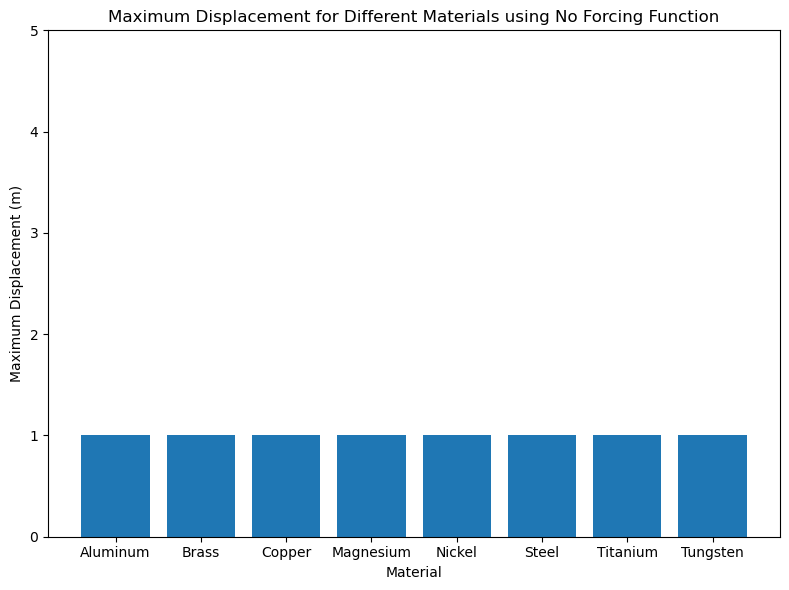

In [326]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.bar(material, max_displacements)
ax1.set_ybound(0, 5)
ax1.set_xticks(np.arange(8), material)
ax1.set_xlabel('Material')
ax1.set_ylabel('Maximum Displacement (m)')
ax1.set_title('Maximum Displacement for Different Materials using No Forcing Function')

In [327]:
material = ['Aluminum', 'Brass', 'Copper', 'Magnesium', 'Nickel', 'Steel', 'Titanium', 'Tungsten']
max_err = [m_e_al, m_e_br, m_e_cu, m_e_mg, m_e_ni, m_e_st, m_e_ti, m_e_tg]
max_err_x = [m_e_x_al, m_e_x_br, m_e_x_cu, m_e_x_mg, m_e_x_ni, m_e_x_st, m_e_x_ti, m_e_x_tg]
print(max_err)

[0.2111185023886171, 0.27405496853315336, 0.632613528256585, 0.2594792696671607, 0.22444539726373533, 0.39058567314336456, 0.6932172201418978, 0.33348774343031634]


Text(0.5, 1.0, 'Maximum Error for Different Materials at Varying $\\Delta t$ Values using No Forcing Function')

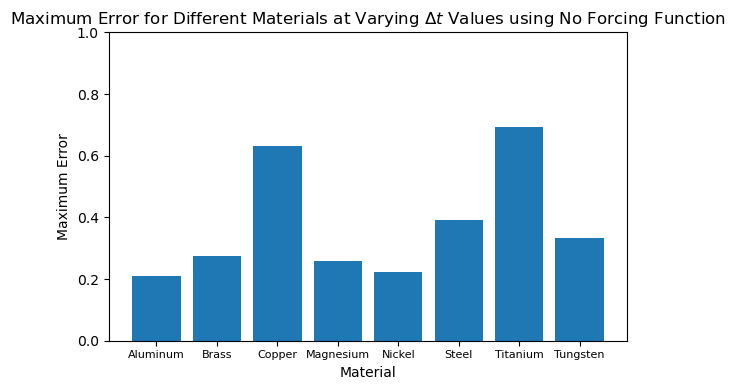

In [328]:
fig = plt.figure(figsize=(6, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.bar(material, max_err)

ax1.set_ybound(0, 1)
ax1.set_xticks(np.arange(8), material, size=8)
ax1.set_xlabel('Material')
ax1.set_ylabel('Maximum Error')
ax1.set_title('Maximum Error for Different Materials at Varying $\Delta t$ Values using No Forcing Function')

Text(0.5, 1.0, 'Maximum Error for Different Materials at Varying $\\Delta x$ Values using No Forcing Function')

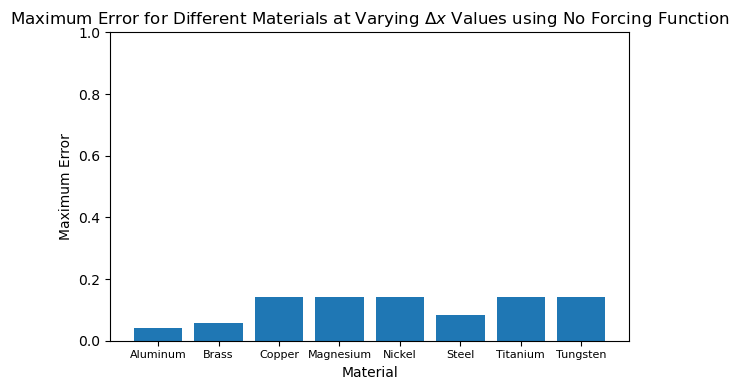

In [329]:
fig = plt.figure(figsize=(6, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.bar(material, max_err_x)

ax1.set_xlabel('Material')
ax1.set_ylabel('Maximum Error')
ax1.set_ybound(0, 1)
ax1.set_xticks(np.arange(8), material, size=8)
ax1.set_title('Maximum Error for Different Materials at Varying $\Delta x$ Values using No Forcing Function')

Trapizoid Absolute Stability



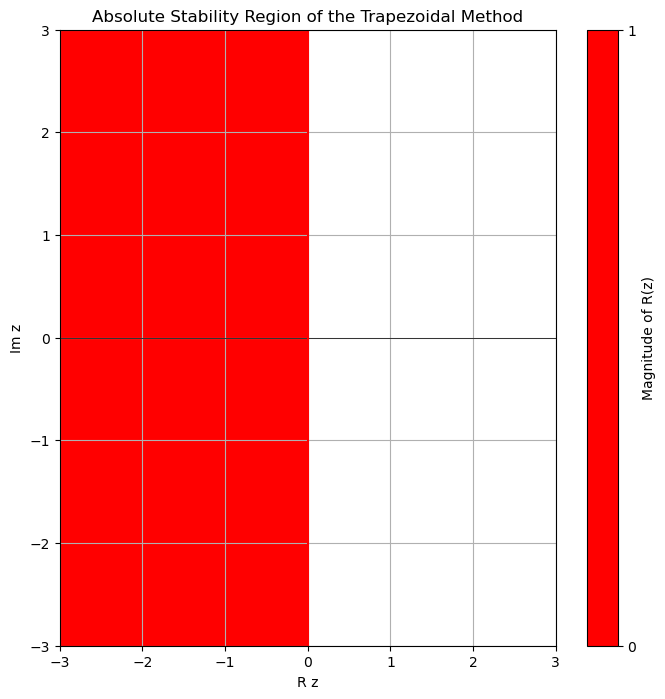

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 300)
y = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

R = (1 + Z / 2) / (1- Z / 2)
magnitude = np.abs(R)

plt.figure(figsize=(8, 8))
plt.contourf(X, Y, magnitude, levels=[0, 1], colors=['red'])
plt.colorbar(label='Magnitude of R(z)')
plt.title('Absolute Stability Region of the Trapezoidal Method')
plt.xlabel('R z')
plt.ylabel('Im z')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.contour(X, Y, magnitude, levels=[1], colors=['red'])
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from matplotlib.animation import FuncAnimation


#Defining the A matrix for space discretization
def A_matrix(n, C):
    A = np.zeros((n, n))
    delta_x = (b-a)/n

    A[0,0] = 1/(C**2)
    A[-1,-1] = 1/(C**2)

    for i in range(n-2):
        A[i+1,i:i+3] = 1, -2, 1
    A = A
    I = np.eye(n)
    return A, I

def uplus1(n, C, T, dt, dx, a, b, f, d, k, k2):
    #Initializing values
    tval = np.arange(0,T+(dt/2), dt)
    xval = np.arange(a, b+(dx/2), dx)
    u = np.zeros((len(tval)-1,n))
    A, I = A_matrix(n, C)

    #Boundary Conditions
    u[:,0] = 0
    for i, t in enumerate(tval):
        u[i:,-1] = d*np.sin(2*np.pi*f*t)*np.exp(-k*t) #Simulated forcing function and first simulated dampening function

    #Initial Conditions
    u[0,:] = 0
    u[1,:] = 0

    for i in range(2,len(tval)-2):
        u[i+1,:] = ((((C**2)*A) @ u[i,:]) + 2*u[i,:] - u[i-1,:])*np.exp(-k2*t) #Second dampening function multiplied to the u(t+1) solution

        #Resetting the boundary conditions because they get altered due to the above operation
        u[:,0] = 0
        for i, t in enumerate(tval):
            u[i:,-1] = d*np.sin(2*np.pi*f*t)*np.exp(-k*t)



    return u, xval, tval

a = 0                           #Initial x position
b = 1                           #Final x position
n = 100                         #Number of xpoints
C = 1                           #Speed of wave propogation based on material properties
T = 40                          #total duration of simulation
f = 5                           #Frequency of propogation
d = 0.3                         #Amplitude of propogation
k = 3                           #First dampening constant
k2 = 0.0005                     #Second dampening constant
dt = 1e-2
dx = (b-a)/n

In [3]:
#Extracting values from our function for given parameters
u, xval, tval = uplus1(n, C, T, dt, dx, a, b, f, d, k, k2)

Text(0, 0.5, 'Deflection')

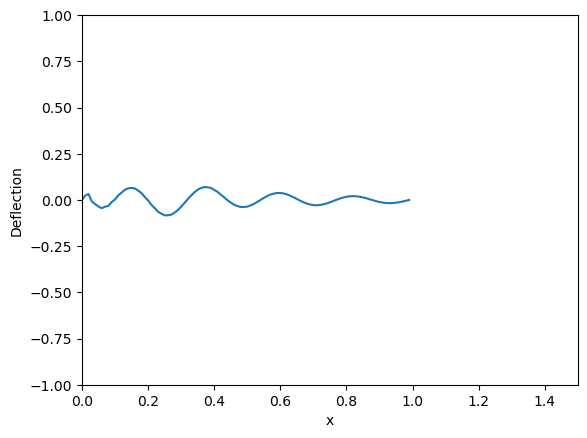

In [4]:
#Plotting a still image of the deflection of the bar over space for a given time
fig, ax = plt.subplots()
ax.plot(xval[0:-1], u[100,:])
ax.set_xlim(0,1.5)
ax.set_ylim(-1,1)
ax.set_xlabel('x')
ax.set_ylabel('Deflection')

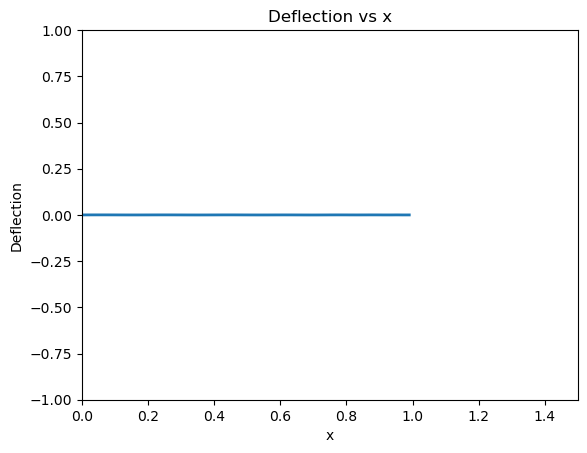

In [6]:
#Code to generate and save animation
fig, ax = plt.subplots()
ax.set_xlim(0, 1.5)
ax.set_ylim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('Deflection')
ax.set_title('Deflection vs x')
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def update(frame):
    x = xval[0:-1]
    y = u[frame,:]
    line.set_data(x, y)
    return line,

animation = FuncAnimation(fig, update, frames=600, init_func=init, blit=True)
animation.save('/Users/philip/Documents/Project2/Vibration.gif', writer='pillow', fps=50)

plt.show()

In [7]:
#Error Calculation

dtList = [2.5e-2, 5e-2, 2.5e-1, 5e-1]
dtBaseline = 1e-2
err = []

utBaseline = uplus1(n, C, T, dtBaseline, dx, a, b, f, d, k, 0.005)[0][0:80,:]
for i in range(4):
    ut = uplus1(n, C, T, dtList[i], dx, a, b, f, d, k, 0.005)[0][0:80,:]
    err.append(np.linalg.norm(ut-utBaseline)/np.linalg.norm(utBaseline))
    print(np.linalg.norm(ut-utBaseline))



1.6378876231964528
1.4269896091429963
1.243219248127439
1.2324835184156733


[1.3289326783873883, 1.1578163827921657, 1.008710647689282, 1.0]


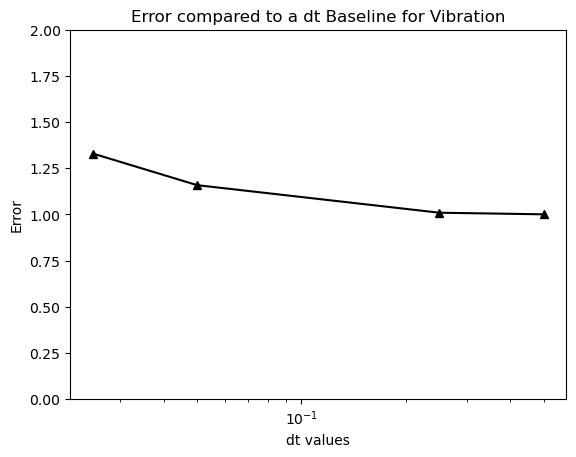

In [9]:
#Error Plotting
fig, ax = plt.subplots()
ax.plot(dtList, err, 'k-^')
ax.set_ylim(0,2)
ax.set_xlabel('dt values')
ax.set_ylabel('Error')
ax.set_xscale('log')
ax.set_title('Error compared to a dt Baseline for Vibration')
print(err)